In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
url = 'C:/Users/china/Downloads/descarga.csv'

df = pd.read_csv(url)
filtro = df["Manabí"][20:]
filtro

20       2
21       3
22       4
23       5
24       8
25       8
26      14
27      21
28      29
29      46
30      72
31      97
32     109
33     129
34     157
35     181
36     207
37     231
38     255
39     285
40     302
41     332
42     365
43     384
44     407
45     424
46     458
47     490
48     517
49     544
50     552
51     578
52     607
53     627
54     655
55     697
56     726
57     741
58     760
59     790
60     810
61     826
62     839
63     866
64     897
65     949
66     970
67     987
68    1011
69    1025
70    1036
71    1044
72    1044
73    1045
74    1046
Name: Manabí, dtype: int64

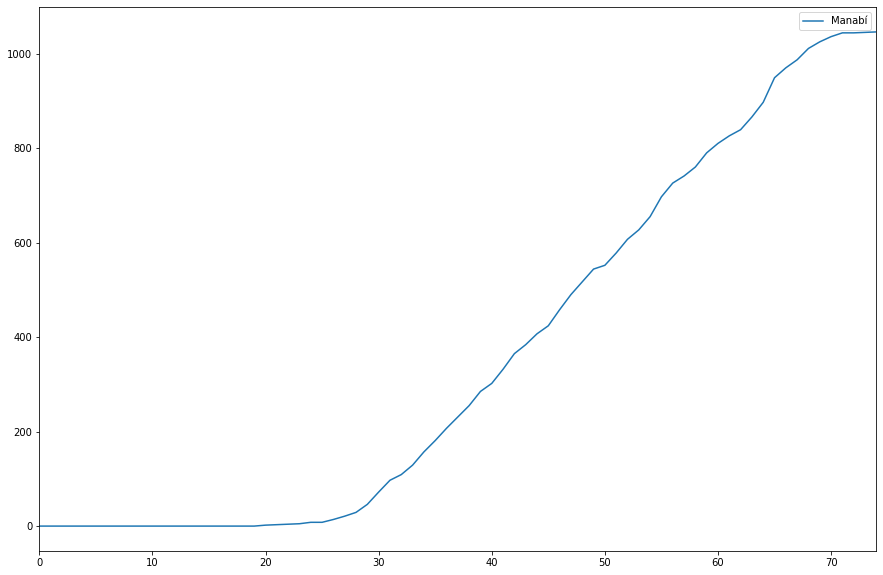

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
df.plot(ax=ax)

In [5]:
##TASA DE CRECIMIENTO POBLACIONAL= 
#(poblacion al final del periodo-poblacion al principio del periodo)/poblacion al principio del periodo
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
i0=2
r0=10
s0=900
x=np.array(range(0,55))
filtro = df["Manabí"][20:]
data= filtro
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00001,0.4), (0.00001, 0.4)])   
beta, gamma = optimal.x
R0= beta/gamma
print("Tasa de crecimiento epidemiologico en manabí")
print(R0)

Tasa de crecimiento epidemiologico en manabí
25.67208223319678


In [7]:
import simpy
import random
import matplotlib.pyplot as pp


#Numero de camas en Manabí
NUM_CAMAS=2000
#Tiempo de consulta = 17min
TIEMPO_CONSULTA=17
#Dias de simulacion = 30
DIAS_SIMULACION=300
#intervalo de llegada de los pacientes 10
INTERVALO_LLEGADA=3
#Cantidad de medicos=93
CANTIDAD_MEDICOS=12000

#COSTO POR PACIENTE= 300$ PRUEBAS ASIGNADAS POR EL MINISTERIO 80$ PRUEBAS A PERSONAS PARTICULARES 180$
COSTO_PACIENTE=80
#RECURSOS/INSUMOS POR DIA PARA UN PACIENTE:
#BATAS=25 unidades
#MASCARILLAS= 25 unididades
#EPP= 1 unidad
#GUANTES= 50 unidades
#PROTECCION OCULAR=1 unidad
#TOTAL DE RECURSOS POR HOSPITAL
TOTAL_RECURSOS=102
TOTAL=1224000
#ROJO= Signos y sintomas graves 50
#AMARILLO = Presencia de sintomas30
#VERDE= Sin factor de riesgo 20


#POBLACION DE MANABI
#NIÑOS=490451
#ADOLESCENTES=129727
#ADULTOS Y ADULTOS MAYORES=750265
#TOTAL=1370443
#INFECTADOS=1046
#POBLACION CON RIESGO DE INFECCION=1369397
MAX_PERSONAS=1369397
#PORCENTAJES EN FASCICULO DE POBLACION
#NIÑOS=35%
#ADOLESCENTES=11%
#ADULTOS Y ADULTOS MAYORES=54%

tiempo={}
tiempo_atencion={}
adultoM_fallecidas={}
adulto_fallecidas={}
ninio_fallecidas={}
personas_atendidas={}
class AtencionPacientes(object):
    def __init__(self, env, num_cama):
        self.env = env
        self.num_cama = num_cama
        self.camas = simpy.Resource(env, num_cama)
        
    def atender_paciente(self, paciente):
        personas_atendidas[env.now]=paciente
        yield self.env.timeout(random.randint(TIEMPO_CONSULTA-2, TIEMPO_CONSULTA+2))
        print("El paciente se termino de atender: ", paciente, " tiempo de salida: ", self.env.now)
        tiempo_atencion[paciente]=env.now
        
def Ingreso_Paciente(env, paciente, consulta):
    llegada= env.now
    medico=0
    poblacion= random.randint(1,100)
    print('Ingreso del paciente con Covid-19 %s a la hora %.2f.' % (paciente, env.now))
    if(poblacion<11):
        riesgo=random.randint(1,20)
    if(poblacion>11 and poblacion<35):
        riesgo=random.randint(20,40)
    if(poblacion>35):
        riesgo=random.randint(40,100)
       
    if(riesgo>40):
        with consulta.camas.request() as cama:
            yield env.process(consulta.atender_paciente(paciente))
            print('Paciente [%s] a finalizado la consulta a las %.2f.' % (paciente, env.now))
            tiempo[paciente]=env.now
            dias_esperando = random.randint(1,2) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimiento = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - llegada
            if cama in requerimiento:
                print("Al paciente: ", paciente, " adulto mayor en estado ROJO se le asigna una CAMA ")
                dias_hospitalizado = random.randint(1,100)
                if(dias_hospitalizado>40):
                    adultoM_fallecidas[env.now]=adultoM_fallecidas[env.now]+ 1 if env.now in adultoM_fallecidas else  1
                    print("El paciente ",paciente,"adulto mayor fallece")
                else:
                    print("El paciente ",paciente," adulto mayor pasa a un estado VERDE y se recupera de COVID-19")
                    
    elif(riesgo>20 and riesgo <40):
         with consulta.camas.request() as cama:
            yield env.process(consulta.atender_paciente(paciente))
            print('Paciente [%s] a finalizado la consulta a las %.2f.' % (paciente, env.now))
            tiempo[paciente]=env.now
            dias_esperando = random.randint(1,5) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimiento = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - llegada
            if cama in requerimiento:
                print("Al paciente: ", paciente, " adulto  en estado AMARILLO se le asigna una CAMA ")
                dias_hospitalizado = random.randint(1,100)
                if(dias_hospitalizado>30):
                    print("El paciente: ", paciente, " pasa a un estado ROJO")
                    dias_hospitalizado = random.randint(1,100)
                    if(dias_hospitalizado>40):
                        adulto_fallecidas[env.now]=adulto_fallecidas[env.now]+ 1 if env.now in adulto_fallecidas else  1
                        print("El paciente ",paciente,"adulto fallece")
                    else:
                        print("El paciente ",paciente,"adulto pasa a un estado VERDE y se recupera de COVID-19")
                else:
                    print("El paciente ",paciente,"adulto pasa a un estado VERDE y se recupera de COVID-19")
    else:
        with consulta.camas.request() as cama:
            yield env.process(consulta.atender_paciente(paciente))
            print('Paciente [%s] a finalizado la consulta a las %.2f.' % (paciente, env.now))
            tiempo[paciente]=env.now
            
            riesgo = random.randint(1,5)
            if (riesgo>3):
                print("Al paciente: ", paciente, " es un niño y se le asigna una CAMA ")
                dias_hospitalizado = random.randint(1,100)
                if(dias_hospitalizado>50):
                    print("El paciente: ", paciente, " es un niño y pasa a un estado ROJO")
                    dias_hospitalizado = random.randint(1,100)
                    if(dias_hospitalizado>60):
                        ninio_fallecidas[env.now]=ninio_fallecidas[env.now]+ 1 if env.now in ninio_fallecidas else  1
                    else:
                        print("El paciente ",paciente,"es un niño y pasa a un estado VERDE y se recupera de COVID-19")
                else:
                    print("El paciente ",paciente,"es un niño pasa a un estado VERDE y se recupera de COVID-19")
            else:
                print("El niño no tiene COVID-19:",paciente)

def ejecutar(env, intervalo_llegada, max_personas):
    consulta=AtencionPacientes(env, NUM_CAMAS)
    for i in range(max_personas):
        env.process(Ingreso_Paciente(env,i, consulta))
        while True:
            yield env.timeout(random.randint(intervalo_llegada-2, intervalo_llegada+2))
            i+=1
            env.process(Ingreso_Paciente(env,i, consulta))
        
env=simpy.Environment()
env.process(ejecutar(env,INTERVALO_LLEGADA,MAX_PERSONAS))

env.run(until =DIAS_SIMULACION)
print("Adultos mayores fallecidas: ")
print(adultoM_fallecidas)
print("Adultos fallecidos: ")
print(adulto_fallecidas)
print("Niños fallecidos: ")
print(ninio_fallecidas)
                

Ingreso del paciente con Covid-19 0 a la hora 0.00.
Ingreso del paciente con Covid-19 1 a la hora 1.00.
Ingreso del paciente con Covid-19 2 a la hora 5.00.
Ingreso del paciente con Covid-19 3 a la hora 8.00.
Ingreso del paciente con Covid-19 4 a la hora 12.00.
El paciente se termino de atender:  0  tiempo de salida:  16
Paciente [0] a finalizado la consulta a las 16.00.
Al paciente:  0  adulto mayor en estado ROJO se le asigna una CAMA 
El paciente  0  adulto mayor pasa a un estado VERDE y se recupera de COVID-19
Ingreso del paciente con Covid-19 5 a la hora 17.00.
El paciente se termino de atender:  1  tiempo de salida:  19
Paciente [1] a finalizado la consulta a las 19.00.
Al paciente:  1  adulto  en estado AMARILLO se le asigna una CAMA 
El paciente:  1  pasa a un estado ROJO
El paciente  1 adulto fallece
El paciente se termino de atender:  2  tiempo de salida:  20
Ingreso del paciente con Covid-19 6 a la hora 20.00.
Paciente [2] a finalizado la consulta a las 20.00.
Al paciente:  2

Adultos mayores


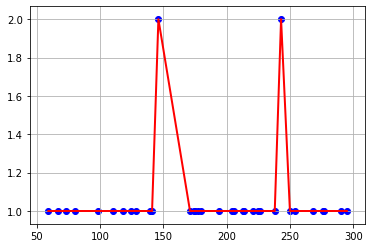

In [9]:
datos=sorted(adultoM_fallecidas.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='red')
pp.scatter(x,y,color='blue')
pp.grid(True)
print("Adultos mayores")
pp.show()

Adultos


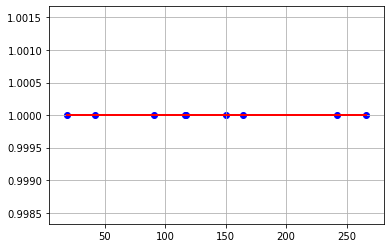

In [10]:
datos=sorted(adulto_fallecidas.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='red')
pp.scatter(x,y,color='blue')
pp.grid(True)
print("Adultos")
pp.show()

Niños


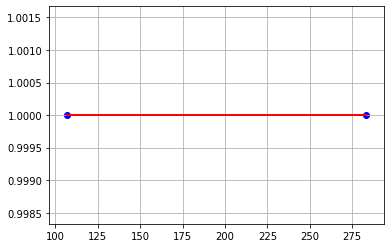

In [11]:
datos=sorted(ninio_fallecidas.items())
x, y =zip(*datos)
pp.plot(x,y,linewidth=2,color='red')
pp.scatter(x,y,color='blue')
pp.grid(True)
print("Niños")
pp.show()